For exploration, we should spread the choices as much as possible. Since we do not want to waste the engergy for searching the same region which may give bad results. The UCB algorithm balance the exploration and exploitation by balancing weights on predicted mean and predicted variance. To check whether UCB algorithm gives a reasonable coverage of the unknown spacing and known spacing, we run a clustering algorithm on the whole exploration space. We expect to cover several sequences in each clustering at the first a few rounds, then focusing more on sequences on the clustering gives a relatively high performance. 


## Pipeline

- Embedding
    - kmers ([3], [2,3,4,5,6])
    - onehot
- PCA
    - number of component (select by singular_values_)
- Clustering (Kmeans++)
    - number of clustering (Elbow method to select good number of clusterings)
- TSNE (to 2 dims) for visualisation
   
## Evaluation

- We show the average value and variance of label for the sequences in each clustering

Ideas:

A possible idea is to combine the clustering and successive rejects, where rejects happens in terms of clusters rather than single data points. This solves the problem that the searching space (number of arms) are too large. 

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.cluster import KMeans
from nltk.metrics import distance 
# import Pycluster as PC
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import math

from codes.kernels_for_GPK import Phi, Spectrum_Kernel, Sum_Spectrum_Kernel
from codes.embedding import Embedding

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## Known seq

In [2]:
import pandas as pd 

Path = '../../../data/firstRound_4h.csv'

df = pd.read_csv(Path)
known_data = np.asarray(df[['RBS', 'AVERAGE']])
known_seq = np.asarray(df['RBS'])

In [3]:
df.head()

,Unnamed: 0,RBS,Name,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,Group,RBS6
0,0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,3.194925,2.783529,1.798618,2.592357,0.717515,0.246643,reference,AGGAGA
1,21,TTTAAGACGGAGATATACAT,RBS_1by1_22,0.636342,0.785468,0.153062,0.524957,0.330589,0.117560,bps_core,CGGAGA
2,22,TTTAAGAGGGAGATATACAT,RBS_1by1_23,-0.616473,-0.502488,0.414480,-0.234827,0.565197,0.043805,bps_core,GGGAGA
3,23,TTTAAGATGGAGATATACAT,RBS_1by1_24,1.249077,0.811791,-0.085595,0.658424,0.680425,0.228128,bps_core,TGGAGA
4,24,TTTAAGAACGAGATATACAT,RBS_1by1_25,1.280146,1.046771,0.953997,1.093638,0.168050,0.193737,bps_core,ACGAGA


In [4]:
known_seq.shape

(150,)

## Setting

In [5]:
random_state = 0
n_dim = 2 # dimension reduction 
scores = {}

In [6]:
def show_tsne_with_clustering(tsne_X, n_clusters, y_km):
    plt.figure(figsize = (15,15))
    for i in range(n_clusters):
        plt.scatter(
            tsne_X[y_km == i, 0], tsne_X[y_km == i, 1],
            s=50, 
            label=str(i)
            )
    plt.legend()
    plt.show()

# Comparision for Kmers embedding

In [7]:
l_list = [3]

kernel = Spectrum_Kernel(l_list = l_list, weight_flag = False, padding_flag = False, gap_flag = False)
distance, X_spec, Y_spec = kernel.distance(known_seq)

#X_spec_pca = PCA(n_components= 15).fit_transform(X_spec)


### select n_components for PCA

In [8]:
pca = PCA(n_components= 64)
pca.fit(X_spec)

PCA(copy=True, iterated_power='auto', n_components=64, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0.5, 0, 'n_components')

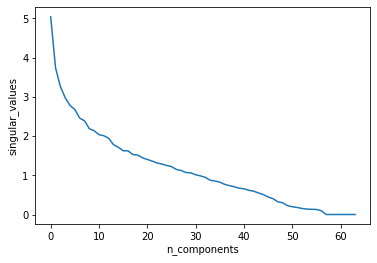

In [9]:
plt.plot(pca.singular_values_)
plt.ylabel('singular_values')
plt.xlabel('n_components')

We decide to select 15 components. 

In [10]:
X_spec_pca = PCA(n_components= 15).fit_transform(X_spec)

In [11]:
tsne = TSNE(n_components = n_dim)
tsne_X_spec = tsne.fit_transform(X_spec_pca)

### Select number of clusterings for Kmeans

In [12]:
sse_spec = []
n_clusters_list = list(range(1,30))

for n_clusters in n_clusters_list:
    kmeans_spec = KMeans(n_clusters=n_clusters, init = 'k-means++', random_state= random_state)
    kmeans_spec.fit(X_spec_pca)
    y_km_spec = kmeans_spec.predict(X_spec_pca)
    sse_spec.append(kmeans_spec.inertia_)

Text(0.5, 1.0, 'Kmers Embedding')

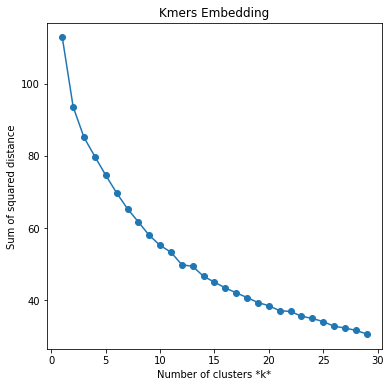

In [13]:
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(n_clusters_list, sse_spec, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.title('Kmers Embedding')

In [19]:
n_clusters = 6
file_name = 'tsne_kmeans++_kmers_3_' +  str(n_clusters) + '_clusters'
print(file_name)

# choose X_spec or tsne_X_spec
kmeans_spec = KMeans(n_clusters=n_clusters, init = 'k-means++', random_state= random_state)
kmeans_spec.fit(X_spec_pca)
y_km_spec = kmeans_spec.predict(X_spec_pca)

# show_tsne_with_clustering(tsne_X_spec, n_clusters, y_km_spec)
np.savez(file_name, coord = tsne_X_spec, text = known_data, ykm = y_km_spec, known_seq = [], ucb_rec = [])
print('result saved')

tsne_kmeans++_kmers_3_6_clusters
result saved
